In [1]:
#@title **Importar bibliotecas necessárias** { vertical-output: true, form-width: "60%" }

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Importar arquivos CSV

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/INFLUD21-01-05-2023.csv', sep=';')



Mounted at /content/drive/


/tmp/ipython-input-2-946287786.py:4: DtypeWarning: Columns (15,59,61,62,63,91,93,105,107,114,116,117,118,122,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/INFLUD21-01-05-2023.csv', sep=';')


## Filtro de colunas

In [55]:
desired_columns = ['DT_NOTIFIC', 'SEM_NOT', 'SEM_PRI', 'SG_UF_NOT','DT_SIN_PRI', 'SG_UF_NOT', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_UNIDADE', 'CO_UNI_NOT', 'CS_SEXO', 'DT_NASC', 'NU_IDADE_N', 'TP_IDADE', 'COD_IDADE', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_PAIS', 'SG_UF', 'ID_RG_RESI', 'CO_RG_RESI', 'ID_MN_RESI', 'CO_MUN_RES', 'CS_ZONA', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO']

## Análise: A taxa de óbito difere entre os sexos?


EVOLUCAO      Cura  Óbito  Total  Taxa_óbito (%)
CS_SEXO_NUM                                     
Masculino    19426   8093  27519       29.408772
Feminino     16116   6365  22481       28.312797



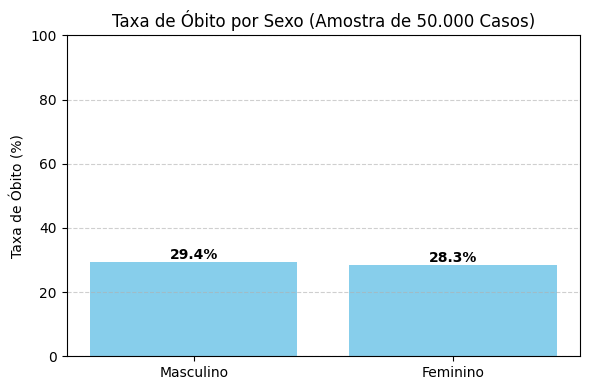

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Mapeamento dos valores de SEXO e EVOLUCAO para 1 e 2. Isso foi feito com a finalidade de facilitar a utilização das colunas
df['CS_SEXO'] = df['CS_SEXO'].astype(str).str.strip().str.upper()
sexo_map = {'M': 1, 'F': 2}
df['CS_SEXO_NUM'] = df['CS_SEXO'].map(sexo_map)
df['EVOLUCAO'] = pd.to_numeric(df['EVOLUCAO'], errors='coerce').astype('Int64')

# Filtragem de dados válidos. Algumas linhas apresentavam valores 'NaN' que estavam afetando a análise, portanto, foi necessário um tratamento prévio
df_validos = df[(df['CS_SEXO_NUM'].isin([1, 2])) & (df['EVOLUCAO'].isin([1, 2]))]

# Sortear amostra com base nos dados filtrados
amostra_50k_taxa_obito = df_validos.sample(n=min(50000, len(df_validos)), random_state=42)

# Tabela de contingência
tabela = pd.crosstab(amostra_50k_taxa_obito['CS_SEXO_NUM'], amostra_50k_taxa_obito['EVOLUCAO'])

# Calcular totais e taxa
tabela['Total'] = tabela[1] + tabela[2]
tabela['Taxa_óbito (%)'] = (tabela[2] / tabela['Total']) * 100

# Renomear índices para leitura
tabela.index = tabela.index.map({1: 'Masculino', 2: 'Feminino'})

# Exibir tabela final
tabela_final = tabela[[1, 2, 'Total', 'Taxa_óbito (%)']].rename(columns={1: 'Cura', 2: 'Óbito'})
print(tabela_final)
print()

# Plotar histograma da taxa de óbito
plt.figure(figsize=(6, 4))
plt.bar(tabela_final.index, tabela_final['Taxa_óbito (%)'], color='skyblue')
plt.title('Taxa de Óbito por Sexo (Amostra de 50.000 Casos)')
plt.ylabel('Taxa de Óbito (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adicionar os valores no topo das barras
for i, v in enumerate(tabela_final['Taxa_óbito (%)']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## Análise: Distribuição dos sintomas de FEBRE, DIARREIA E TOSSE entre gestantes


Total de gestantes (1º ao 3º trimestre) encontradas no dataset: 16140
Proporção de gestantes na base: 0.93%

Distribuição de sintomas entre gestantes:


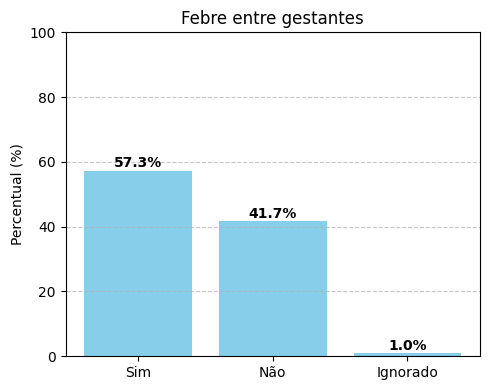


Idade média das gestantes com febre: 28.91 anos


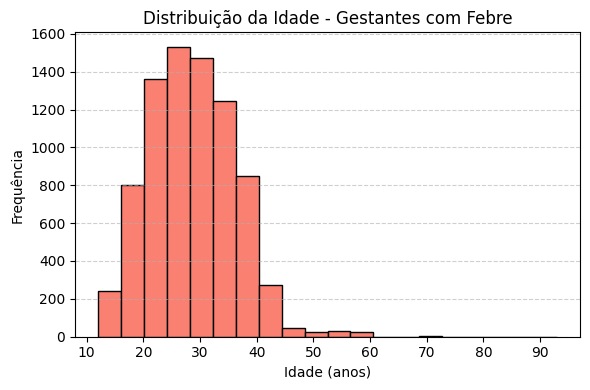

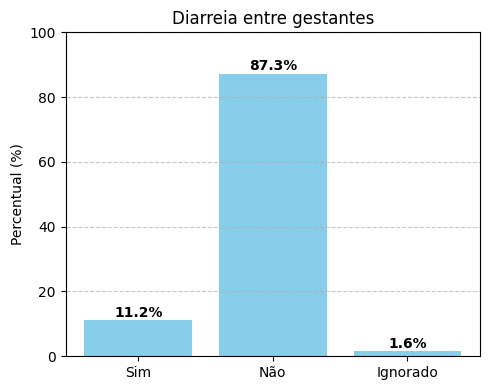


Idade média das gestantes com diarreia: 29.62 anos


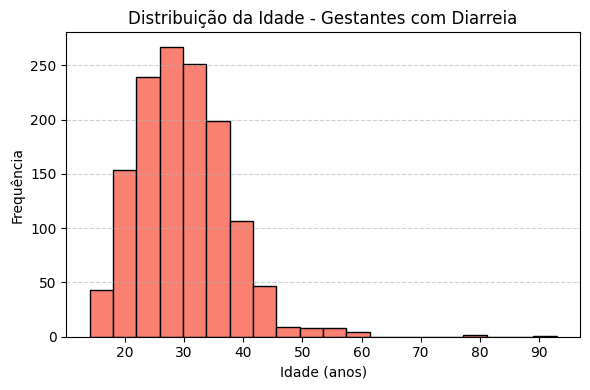

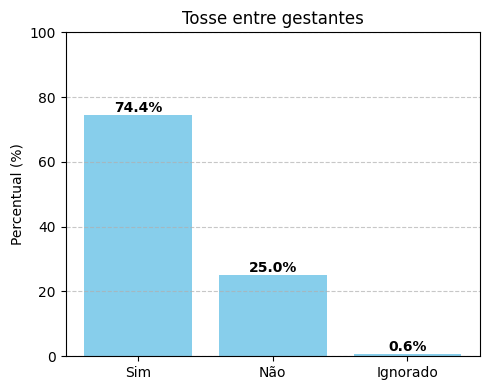


Idade média das gestantes com tosse: 29.22 anos


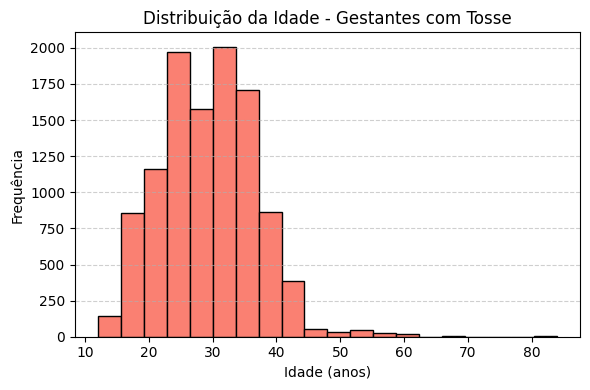

In [3]:
# Garantir que as colunas estão no tipo certo para serem analisadas
df['CS_GESTANT'] = pd.to_numeric(df['CS_GESTANT'], errors='coerce').astype('Int64')
df['FEBRE'] = pd.to_numeric(df['FEBRE'], errors='coerce').astype('Int64')
df['DIARREIA'] = pd.to_numeric(df['DIARREIA'], errors='coerce').astype('Int64')
df['TOSSE'] = pd.to_numeric(df['TOSSE'], errors='coerce').astype('Int64')

# Filtrar os casos de gestantes (valores 1, 2 ou 3)
gestantes = df[df['CS_GESTANT'].isin([1, 2, 3])]

# Mostrar contagens
total_geral = df.shape[0]
total_gestantes = gestantes.shape[0]
proporcao = (total_gestantes / total_geral) * 100

print(f"Total de gestantes (1º ao 3º trimestre) encontradas no dataset: {total_gestantes}")
print(f"Proporção de gestantes na base: {proporcao:.2f}%")

# Análise de sintomas entre gestantes
print("\nDistribuição de sintomas entre gestantes:")

# Mapeamento para rótulos
rotulos = {1: 'Sim', 2: 'Não', 9: 'Ignorado'}

# Gráficos de sintomas
for sintoma in ['FEBRE', 'DIARREIA', 'TOSSE']:
    contagem = gestantes[sintoma].value_counts(normalize=True).sort_index() * 100
    contagem = contagem.rename(index=rotulos)

    plt.figure(figsize=(5, 4))
    bars = plt.bar(contagem.index, contagem.values, color='skyblue')
    plt.title(f'{sintoma.capitalize()} entre gestantes')
    plt.ylabel('Percentual (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Rótulos no topo das barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
    print()

    # Filtro para selecionar apenas resultados positivos e adiciona uma verificação na coluna da idade
    gestantes_com_sintoma = gestantes[(gestantes[sintoma] == 1) & (gestantes['NU_IDADE_N'].notna())]

    if not gestantes_com_sintoma.empty:
        media_idade = gestantes_com_sintoma['NU_IDADE_N'].mean()
        print(f"Idade média das gestantes com {sintoma.lower()}: {media_idade:.2f} anos")
        plt.figure(figsize=(6, 4))
        plt.hist(gestantes_com_sintoma['NU_IDADE_N'], bins=20, color='salmon', edgecolor='black')
        plt.title(f'Distribuição da Idade - Gestantes com {sintoma.capitalize()}')
        plt.xlabel('Idade (anos)')
        plt.ylabel('Frequência')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    print()
